# Credit Card Transactions

In [121]:
#!pip install tensorflow --upgrade

In [122]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lightgbm import plot_importance
%matplotlib inline

class SilentRegressor(lgb.LGBMRegressor):
    def fit(self, *args, **kwargs):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            return super().fit(*args, verbose=False, **kwargs)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [123]:
# cct - credit card transactions
cct1 = pd.read_csv('/Users/jasonrobinson/Documents/Data-Engineering-Credit-Card-Transactions/transactions.csv')
#cct2 =  pd.read_csv('/Users/jasonrobinson/Documents/cc-transact-csv/credit_card_transactions-ibm_v2.csv')
cards = pd.read_csv('/Users/jasonrobinson/Documents/cc-transact-csv/sd254_cards.csv')
users = pd.read_csv('/Users/jasonrobinson/Documents/cc-transact-csv/sd254_users.csv')

In [124]:
# Shape of each dataset
print(cct1.shape, cards.shape, users.shape )
cct1.head()

(19963, 15) (6146, 13) (2000, 18)


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [125]:
cct1 = cct1.drop(['Merchant State','Errors?'], axis=1)

## Preprocessing

In [126]:
cct1['Zip'] = cct1['Zip'].fillna(0)
cct1['Amount'] = cct1['Amount'].apply(lambda value: float(value.split("$")[1]))
cct1['Hour'] = cct1['Time'].apply(lambda value: int(value.split(":")[0]))
cct1['Minutes'] = cct1['Time'].apply(lambda value: int(value.split(":")[1]))
cct1.drop(['Time'], axis=1, inplace=True)
cct1['Merchant Name'] = cct1['Merchant Name'].astype("object")
cct1['Card'] = cct1['Card'].astype("object")
cct1['Use Chip'] = cct1['Use Chip'].astype("object")
cct1['MCC'] = cct1['MCC'].astype("object")
cct1['Zip'] = cct1['Zip'].astype("object")

In [127]:
for col in cct1.columns:
    col_type = cct1[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        cct1[col] = cct1[col].astype('category')

In [128]:
# Split our dataset in X and Y
y = cct1['Is Fraud?'].apply(lambda value: 1 if value == 'Yes' else 0)
X = cct1.drop(['Is Fraud?'],axis=1)

In [129]:
categorical_column_names = []
categorical_cols = []
for idx,col in enumerate(X.columns):
    col_type = X[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        categorical_column_names.append(col)
        categorical_cols.append(idx)

In [130]:
categorical_column_names.append("Zip")
categorical_column_names.append("MCC")
categorical_column_names.append("Card")
categorical_column_names.append("Merchant Name")

In [131]:
categorical_names = {}
for feature in categorical_column_names:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(X.loc[:, feature])
    X.loc[:, feature] = le.transform(X.loc[:, feature])
    categorical_names[feature] = le.classes_

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)

In [133]:
# Train our lgbm model
model = lgb.LGBMClassifier(n_estimators=100, 
                           num_leaves=30, 
                           max_depth=50, 
                           learning_rate=0.01, 
                           random_state=42, 
                           n_jobs=-1)
model.fit(X_train, y_train,
          feature_name='auto',
          categorical_feature=categorical_column_names,
          eval_set=[(X_test, y_test)],
          eval_metric='auc',
          early_stopping_rounds=20)

[1]	valid_0's auc: 0.89664	valid_0's binary_logloss: 0.00761146
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.819709	valid_0's binary_logloss: 0.00706605
[3]	valid_0's auc: 0.836309	valid_0's binary_logloss: 0.00691063
[4]	valid_0's auc: 0.856018	valid_0's binary_logloss: 0.00680258
[5]	valid_0's auc: 0.848646	valid_0's binary_logloss: 0.00675786
[6]	valid_0's auc: 0.847844	valid_0's binary_logloss: 0.0066828
[7]	valid_0's auc: 0.856745	valid_0's binary_logloss: 0.00661548
[8]	valid_0's auc: 0.856745	valid_0's binary_logloss: 0.0065569
[9]	valid_0's auc: 0.859403	valid_0's binary_logloss: 0.00647836
[10]	valid_0's auc: 0.859002	valid_0's binary_logloss: 0.006404
[11]	valid_0's auc: 0.868129	valid_0's binary_logloss: 0.00630593
[12]	valid_0's auc: 0.867778	valid_0's binary_logloss: 0.00621147
[13]	valid_0's auc: 0.867879	valid_0's binary_logloss: 0.00614789
[14]	valid_0's auc: 0.863967	valid_0's binary_logloss: 0.00609676
[15]	valid_0's auc: 0.863917	

LGBMClassifier(learning_rate=0.01, max_depth=50, num_leaves=30, random_state=42)

In [134]:
y_pred=model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3988
           1       0.00      0.00      0.00         5

    accuracy                           1.00      3993
   macro avg       0.50      0.50      0.50      3993
weighted avg       1.00      1.00      1.00      3993



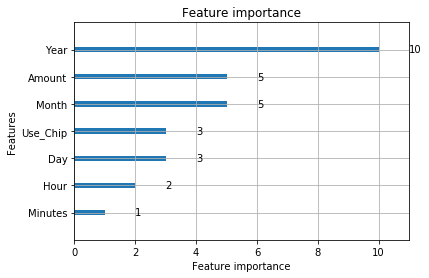

In [136]:
plot_importance(model);

In [76]:
np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

((15970, 13), (15970,), (3993, 13), (3993,))

In [87]:
# Save the model to disk
import pickle
clf_model = 'prediction_model5.pkl'
pickle.dump(model, open(clf_model, 'wb'))


In [88]:
# Load the model from disk
loaded_model = pickle.load(open(clf_model, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9979964938642625


In [137]:
# Predict the response for test dataset
y_pred = loaded_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [138]:
import sklearn.metrics

print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))
#print("Precision:",sklearn.metrics.precision_score(y_test, y_pred))
#print("Recall:",sklearn.metrics.recall_score(y_test, y_pred))
#print("F1:",sklearn.metrics.f1_score(y_test, y_pred))
#print("ROC:",sklearn.metrics.roc_auc_score(y_test, y_pred))
#print("Confusion Matrix:",sklearn.metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9979964938642625


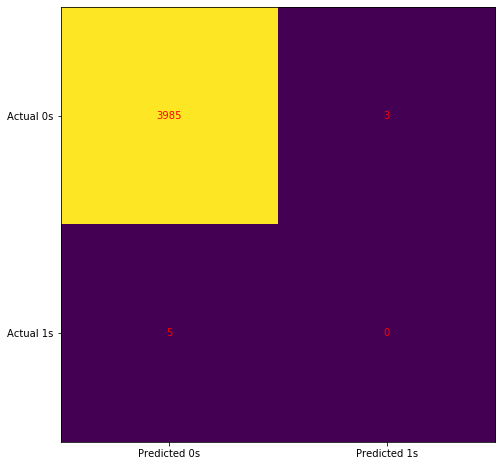

In [139]:
# Create a function to plot the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range():
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

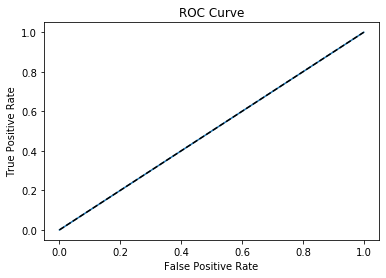

In [115]:
# Create a function to plot the ROC curve
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
plot_roc_curve(y_test, y_pred)